In [37]:
from datasets import load_dataset
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import Dataset, DataLoader

USE_IMAGENET_DATASET = False


class HFDataset(Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()

        self.dataset = dataset

    def __getitem__(self, index):
        data = self.dataset[index]
        return data["pixel_values"], data["label"]

    def __len__(self):
        return len(self.dataset)


def transforms(examples):
    examples["pixel_values"] = [
        transforms_list(image.convert("RGB")) for image in examples["image"]
    ]
    return examples


transforms_list = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
        Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

if USE_IMAGENET_DATASET:
    dataset = {}
    for split in ["train", "validation", "test"]:
        dataset[split] = load_dataset("ILSVRC/imagenet-1k", trust_remote_code=True, split=split)


    dataset["train"].set_transform(transforms)
    dataset["validation"].set_transform(transforms)
    dataset["test"].set_transform(transforms)


    train_dataset = HFDataset(dataset["train"])
    validation_dataset = HFDataset(dataset["validation"])

In [104]:
import torch
from torch import nn
from types import MethodType
from copy import deepcopy
from ramp_gae.utils import normalize_abs_sum_to_one, normalize_relevance, NormalizationType
import timm
from timm.models.resnet import BasicBlock, Bottleneck
import sys

def print_positive_negative(relevance: torch.tensor) -> None:
    print("pos", relevance[0].relu().sum(), "neg", (-relevance).relu().sum())

# model = timm.create_model("vgg16", pretrained=True)
model = timm.create_model("resnet18", pretrained=True)
model.eval()


class LRPRule:
    def __init__(self):
        self.module_to_rule_dict = {}
        self.default_rule = None

    def rule_for_layer(self, module: nn.Module):
        for module_class, rule in self.module_to_rule_dict.items():
            if isinstance(module, module_class):
                return rule
        return self.default_rule


class VGGAbsLRPRule(LRPRule):
    def __init__(self):
        self.module_to_rule_dict = {}#nn.MaxPool2d: divide_abslrp_rule}
        self.default_rule = abslrp_rule


class ResNetAbsLRPRule(LRPRule):
    def __init__(self):
        self.module_to_rule_dict = {
        }  # nn.MaxPool2d: divide_abslrp_rule}
        self.default_rule = abslrp_rule

class ResidualAddition(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, x1: torch.tensor, x2: torch.tensor) -> torch.tensor:
        return x1 + x2


def modified_basic_block_forward(self, x: torch.tensor) -> torch.tensor:
    shortcut = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.drop_block(x)
    x = self.act1(x)
    x = self.aa(x)

    x = self.conv2(x)
    x = self.bn2(x)

    if self.se is not None:
        x = self.se(x)

    if self.drop_path is not None:
        x = self.drop_path(x)

    if self.downsample is not None:
        shortcut = self.downsample(shortcut)
    x = self.residual_addition(x, shortcut)
    x = self.act2(x)

    return x


def modified_bottleneck_forward(self, x: torch.tensor) -> torch.tensor:
    shortcut = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.drop_block(x)
    x = self.act1(x)
    x = self.aa(x)

    x = self.conv2(x)
    x = self.bn2(x)

    if self.se is not None:
        x = self.se(x)

    if self.drop_path is not None:
        x = self.drop_path(x)

    if self.downsample is not None:
        shortcut = self.downsample(shortcut)
    x = self.residual_addition(x, shortcut)
    x = self.act2(x)

    return x


def basic_block_explain(
    self, output_relevance: torch.tensor, retain_graph: bool = False
) -> torch.tensor:
    output_relevance = self.act2.explain(output_relevance, retain_graph)
    output_relevance, shortcut_relevance = self.residual_addition.explain(output_relevance, retain_graph=True)
    if self.downsample is not None:
        shortcut_relevance = self.downsample.explain(shortcut_relevance, retain_graph)
    if self.drop_path is not None:
        output_relevance = self.drop_path.explain(output_relevance, retain_graph)
    if self.se is not None:
        output_relevance = self.se.explain(output_relevance, retain_graph)
    output_relevance = self.bn2.explain(output_relevance, retain_graph)
    output_relevance = self.conv2.explain(output_relevance, retain_graph)
    output_relevance = self.aa.explain(output_relevance, retain_graph)
    output_relevance = self.act1.explain(output_relevance, retain_graph)
    output_relevance = self.drop_block.explain(output_relevance, retain_graph)
    output_relevance = self.bn1.explain(output_relevance, retain_graph)
    output_relevance = self.conv1.explain(output_relevance, retain_graph)

    output_relevance = output_relevance + shortcut_relevance

    return output_relevance


def identity_rule(self, output_relevance: torch.tensor) -> torch.tensor:
    return output_relevance


def abslrp_rule(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    input = self.saved_tensors["input"]
    output = self.saved_tensors["output"]
    if "abs_output" in self.saved_tensors:
        output = output + self.saved_tensors["abs_output"]
    output_relevance = output_relevance / (self.saved_tensors["output"].abs() + 1e-9)
    # apply abslrp rule to each input
    grads = torch.autograd.grad(output, input, output_relevance, retain_graph=retain_graph)
    relevances = [arg * grad for arg, grad in zip(input, grads)]
    # normalize relevances
    relevances = [normalize_relevance(relevance=relevance, normalization_type=NormalizationType.SUM_TO_ONE) for relevance in relevances]
    #print(self.__class__.__name__, end=' ')
    #print_positive_negative(relevance=relevance)
    # delete saved tensors if not needed
    if not retain_graph:
        self.saved_tensors = {}
    if len(relevances) == 1:
        return relevances[0]
    return relevances

def divide_abslrp_rule(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    input = self.saved_tensors["input"][0]
    output = self.saved_tensors["output"]
    if "abs_output" in self.saved_tensors:
        output = output + self.saved_tensors["abs_output"]
    output_relevance = output_relevance
    # apply abslrp rule
    relevance = torch.autograd.grad(output, input, output_relevance, retain_graph=retain_graph)[0] * input
    relevance = normalize_relevance(relevance=relevance, normalization_type=NormalizationType.SUM_TO_ONE)
    #print("single", self, relevance.shape)
    #print(self.__class__.__name__, end=' ')
    #print_positive_negative(relevance=relevance)
    # delete saved tensors if not needed
    if not retain_graph:
        self.saved_tensors = {}
    return relevance


def composite_abslrp_rule(self, output_relevance: torch.tensor, retain_graph: bool = False) -> torch.tensor:
    for child in list(self.children())[::-1]:
        #print("composite", child, output_relevance.shape)
        output_relevance = child.explain(output_relevance=output_relevance, retain_graph=retain_graph)
    return output_relevance


def abslrp_forward_hook(module: nn.Module, args: tuple, output: torch.tensor) -> None:
    module.saved_tensors = {}
    # create a temporary temp module
    abs_module = deepcopy(module)
    # remove this hook from copied model
    if getattr(abs_module, "_forward_hooks", None):
        for i, hook in abs_module._forward_hooks.items():
            if hook.__name__ == "abslrp_forward_hook":
                break
        del abs_module._forward_hooks[i]
    # if module has learnable parameters, infer over absolute parameters
    if getattr(module, "weight", None) is not None:
        abs_module.weight.data = abs_module.weight.data.abs()
        if getattr(module, "bias", None) is not None:
            abs_module.bias.data = abs_module.bias.data.abs()
    abs_output = abs_module(*[arg.abs() for arg in args])
    # save the outputs and inputs
    #print(module.__class__.__name__, args[0].shape, output.shape)
    module.saved_tensors["abs_output"] = abs_output
    module.saved_tensors["output"] = output
    module.saved_tensors["input"] = args


def apply_rule(module: nn.Module, rule: LRPRule) -> list[nn.Module]:
    if not list(module.children()):
        explain_func = rule.rule_for_layer(module)
        module.explain = MethodType(explain_func, module)
        module.register_forward_hook(abslrp_forward_hook)
        return

    # print(module)
    if isinstance(module, BasicBlock):
        module.add_module("residual_addition", ResidualAddition())
        print("YE LAD")
        module.forward = MethodType(modified_basic_block_forward, module)
        module.explain = MethodType(basic_block_explain, module)
    else:
        # print()
        module.explain = MethodType(composite_abslrp_rule, module)
    for child_module in list(module.children()):
        apply_rule(child_module, rule=rule)

    return


apply_rule(model, VGGAbsLRPRule() if isinstance(model, timm.models.vgg.VGG) else ResNetAbsLRPRule())

YE LAD
YE LAD
YE LAD
YE LAD
YE LAD
YE LAD
YE LAD
YE LAD


In [105]:
"""model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 2, bias=False))

model[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])
model[1].weight.data = torch.tensor([[1.0, 0], [0, 1]])

x = torch.tensor([[1.0, 1]])
x.requires_grad = True

apply_rule(model, AbsLRPRule())

model(x), model.explain(torch.tensor([[1.0, -1]]))"""

'model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 2, bias=False))\n\nmodel[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])\nmodel[1].weight.data = torch.tensor([[1.0, 0], [0, 1]])\n\nx = torch.tensor([[1.0, 1]])\nx.requires_grad = True\n\napply_rule(model, AbsLRPRule())\n\nmodel(x), model.explain(torch.tensor([[1.0, -1]]))'

In [106]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (residual_addition): ResidualAddition()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [107]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image

if USE_IMAGENET_DATASET:
    validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)
    for x, y in validation_loader:
        break
else:
    image = Image.open("images/dog_cat.jpeg").convert("RGB")
    x = transforms_list(image)[None]

x.requires_grad = True
output = model(x)
s_output = output.softmax(-1)

# sglrp
#output_relevance = torch.autograd.grad(s_output.sum(), output)[0]
# clrp
output_relevance = torch.ones_like(output)
positive_mask = F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])

positive_relevance = model.explain(output_relevance=(output_relevance * positive_mask).abs(), retain_graph=True)
negative_relevance = model.explain(output_relevance=(output_relevance * (1 - positive_mask)).abs())

relevance = positive_relevance - negative_relevance

print(relevance[0].sum())

act2 torch.Size([1, 512, 7, 7])
resadd torch.Size([1, 512, 7, 7])
bn2 torch.Size([1, 512, 7, 7])
act2 torch.Size([1, 512, 7, 7])
resadd torch.Size([1, 512, 7, 7])
downsample torch.Size([1, 256, 14, 14])
bn2 torch.Size([1, 512, 7, 7])
act2 torch.Size([1, 256, 14, 14])
resadd torch.Size([1, 256, 14, 14])
bn2 torch.Size([1, 256, 14, 14])
act2 torch.Size([1, 256, 14, 14])
resadd torch.Size([1, 256, 14, 14])
downsample torch.Size([1, 128, 28, 28])
bn2 torch.Size([1, 256, 14, 14])
act2 torch.Size([1, 128, 28, 28])
resadd torch.Size([1, 128, 28, 28])
bn2 torch.Size([1, 128, 28, 28])
act2 torch.Size([1, 128, 28, 28])
resadd torch.Size([1, 128, 28, 28])
downsample torch.Size([1, 64, 56, 56])
bn2 torch.Size([1, 128, 28, 28])
act2 torch.Size([1, 64, 56, 56])
resadd torch.Size([1, 64, 56, 56])
bn2 torch.Size([1, 64, 56, 56])
act2 torch.Size([1, 64, 56, 56])
resadd torch.Size([1, 64, 56, 56])
bn2 torch.Size([1, 64, 56, 56])
act2 torch.Size([1, 512, 7, 7])
resadd torch.Size([1, 512, 7, 7])
bn2 torch

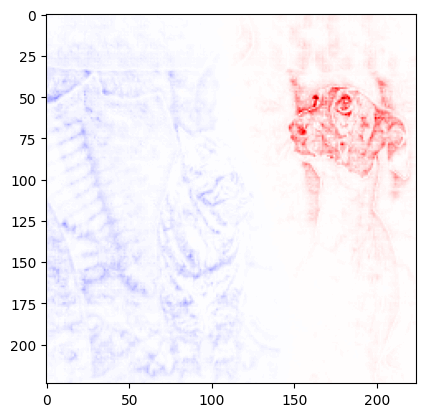

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline
from ramp_gae.utils import normalize_relevance, NormalizationType

vis_example = 0
plt.imshow(normalize_relevance(relevance.sum(1), normalization_type=NormalizationType.MAX_TO_ONE)[vis_example].detach().cpu(), vmin=-1, vmax=1, cmap="seismic")
plt.show()

In [ ]:
x.requires_grad = True
output = model(x)
output_relevance = F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])
positive_relevance = model.explain(output_relevance=output_relevance)

output = model(x)
output_relevance = 1 - F.one_hot(output.max(-1)[1], num_classes=output.shape[-1])
negative_relevance = model.explain(output_relevance=output_relevance)

relevance = normalize_abs_sum_to_one(positive_relevance) - normalize_abs_sum_to_one(negative_relevance)

output tensor(1)
<class 'torch.nn.modules.linear.Linear'> tensor(1.) tensor(1) tensor(0) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.dropout.Dropout'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.flatten.Flatten'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'> tensor(1.) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.)
<class 'torch.nn.modules.conv.Conv2d'> tensor(1.0000) tensor(1.) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.0000)
<class 'torch.nn.modules.dropout.Dropout'> tensor(1.0000) tensor(1.0000) tensor(0.) sum_abssum tensor(0., grad_fn=<SumBackward0>) tensor(0.)
output tensor(1.0000)
<class 'torch.nn.modules.conv.Conv2d'> tensor(1.0000) t

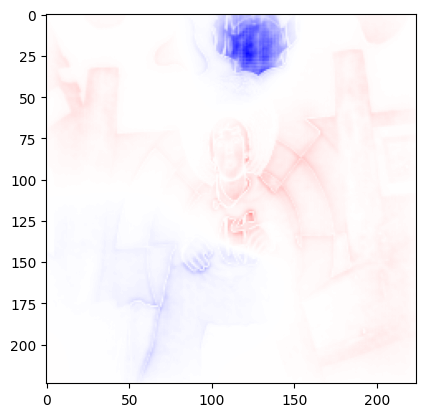

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from ramp_gae.utils import normalize_relevance, NormalizationType

vis_example = 7
plt.imshow(normalize_relevance(relevance.sum(1), normalization_type=NormalizationType.MAX_TO_ONE)[vis_example].detach().cpu(), vmin=-1, vmax=1, cmap="bwr")
plt.show()

# Test model

In [ ]:
model = nn.Sequential(nn.Linear(2, 2, bias=False), nn.Linear(2, 1, bias=False))

model[0].weight.data = torch.tensor([[2.0, -1], [-5, 6]])
model[1].weight.data = torch.tensor([[1.0, 1]])

x = torch.tensor([[1.0, 1]])
x.requires_grad = True

apply_rule(model, AbsLRPRule())

model(x), model.explain(torch.tensor([[1.0]]))

layer = nn.Linear(2, 2, bias=False)
layer.weight.data = torch.tensor([[2.0, -1], [-5, 6]])
abs_layer = deepcopy(layer)
abs_layer.weight.data = abs_layer.weight.data.abs()

h = layer(x)
ha = abs_layer(x)

torch.autograd.grad(h + ha, x, torch.tensor([[0.5, 0.5]]) / h.abs())[0] * x